In [1]:
import subprocess
subprocess.check_output(["maturin", "develop"])
import time

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/wint3rmute/code/luthier/.venv/bin/python
📡 Using build options features from pyproject.toml
   Compiling pyo3-build-config v0.18.3
   Compiling pyo3-ffi v0.18.3
   Compiling pyo3 v0.18.3
   Compiling numpy v0.18.0
   Compiling luthier v0.1.0 (/home/wint3rmute/code/luthier)
   --> src/ladder_filter.rs:131:8
    |
110 | impl LadderFilter {
    | ----------------- method in this implementation
...
131 |     fn run_ladder_nonlinear(&mut self, input: f64) {
    |        ^^^^^^^^^^^^^^^^^^^^
    |
    = note: `#[warn(dead_code)]` on by default

    Finished dev [unoptimized + debuginfo] target(s) in 5.00s
📦 Built wheel for CPython 3.10 to /tmp/.tmpCoLvfS/luthier-0.1.0-cp310-cp310-linux_x86_64.whl
🛠 Installed luthier-0.1.0


In [2]:
from luthier.luthier import DspGraph, SineOscillator, Multiplier, HarmonicMultiplier, Sum, ADSR, LowPassFilter, SquareOscillator
from IPython.display import Audio, display, Image, HTML
from luthier.dsp import Sample, SAMPLE_RATE
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm.notebook import tqdm
from scipy.optimize import differential_evolution
import numpy as np
from IPython.display import clear_output

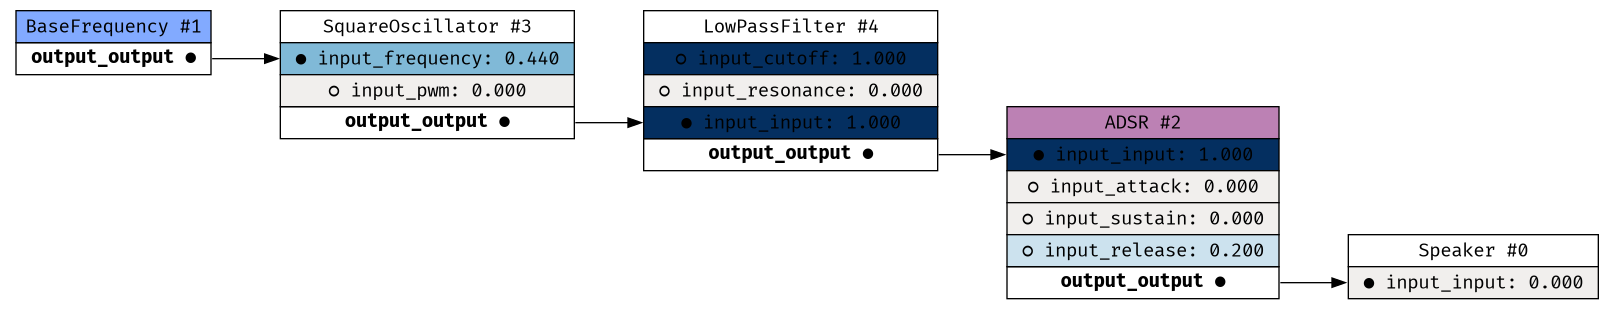

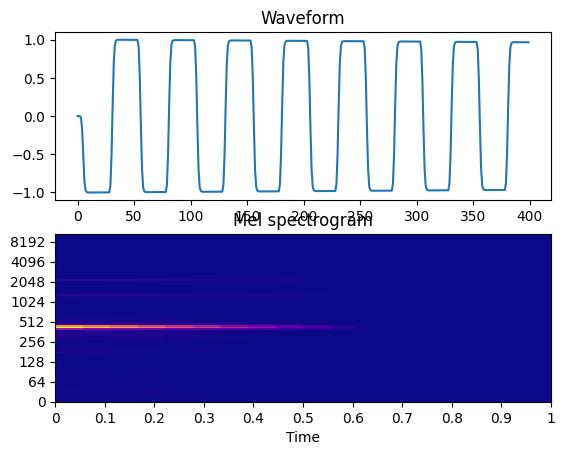

In [7]:
graph = DspGraph()
s = SquareOscillator()
s.input_pwm = 0.0
s = graph.add_square(s)

f = LowPassFilter()
f = graph.add_lowpass(f)

graph.patch(s, "output_output", f, "input_input")

graph.patch(f, "output_output", graph.amp_adsr_node_id, "input_input")
graph.patch(1, "output_output", s, "input_frequency")

graph.set_input(2, "input_attack", 0.0001)
graph.set_input(2, "input_sustain", 0.0)
graph.set_input(2, "input_release", 0.2)

graph.set_input(f, "input_cutoff", 1.0)
graph.set_input(f, "input_resonance", 0.0)

audio = Sample(graph.play(SAMPLE_RATE))
display(Image(graph.draw()))

fig, (ax, ax2) = plt.subplots(2)
audio.plot_waveform(ax)
audio.plot_spectrogram(ax2)
audio.show_player()

plt.show()

In [4]:
print(123)

123
